# <center>Freesound General-Purpose Audio Tagging Challenge</center>  
<center>Freesound通用音频标注挑战  </center>  


![Logo](https://upload.wikimedia.org/wikipedia/commons/3/3c/Freesound_project_website_logo.png)

Freesound is a collaborative database of Creative Commons Licensed sounds. The aim of this competition is to classify audio files that cover real-world sounds from musical instruments, humans, animals, machines, etc. Few of the labels are: `Trumpet`, `Squeak`, `Meow`, `Applause` and `Finger_sapping`.  One of the challenges is that not all labels are manually verified. A creative solution should be able to partially rely on these *weak* annotations.  
Freesound是Creative Commons Licensed声音的协作数据库。 本次比赛的目的是对音频文件进行分类，这些文件涵盖乐器，人类，动物，机器等真实世界的声音。很少量的标签是：小号，吱吱声，喵喵声，掌声和打响指。其中一个挑战是并非所有标签都经过了人工验证。创造性的解决方案应该能够部分依赖这些弱注释。  

Let's take a tour of the data visualization and model building through this kernel. If you like this work, please show your support by upvotes. Happy Kaggling!  
让我们通过这个内核浏览数据可视化和模型构建。 如果您喜欢这项工作，请通过upvotes表示您的支持。 快乐的Kaggling！  
翻译注释：七月在线fan  


### Contents
1. [Exploratory Data Analysis](#eda)探索性数据分析
    * [Loading data](#loading_data)加载数据
    * [Distribution of Categories](#distribution)类的分布
    * [Reading Audio Files](#audio_files)浏览音频文件
    * [Audio Length](#audio_length)音频长度
2. [Building a Model using Raw Wave](#1d_model_building)使用原始波建立模型
    * [Model Discription](#1d_discription)模型描述
    * [Configuration](#configuration)结构
    * [DataGenerator class](#data_generator)数据生成器
    * [Normalization](#1d_normalization)1d归一化
    * [Training 1D Conv](#1d_training) 训练1维卷积神经网络
    * [Ensembling 1D Conv Predictions](#1d_ensembling)集成一维卷积的预测结果
3. [Introduction to MFCC](#intro_mfcc)MFCC简介
    * [Generating MFCC using Librosa](#librosa_mfcc)使用Librosa生成MFCC
4. [Building a Model using MFCC](#2d_model_building)使用MFCC构建模型
    * [Preparing Data](#2d_data)准备数据
    * [Normalization](#2d_normalization)归一化
    * [Training 2D Conv on MFCC](#2d_training)训练MFCC的2D Conv
    * [Ensembling 2D Conv Predictions](#2d_ensembling)集成2D Conv的预测结果
5. [Ensembling 1D Conv and 2D Conv Predictions](#1d_2d_ensembling)集成1D Conv和2D Conv的预测结果
6. [Results and Conclusion](#conclusion)结果和结论  

参考：  
https://www.jianshu.com/p/880bd818fca0  
https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data  


<a id="eda"></a>
## <center>1. Exploratory Data Analysis探索性数据分析</center>

In [ ]:
# Change this to True to replicate the result
COMPLETE_RUN = False
#True代表运行全部数据集，False代表运行部分数据集

<a id="loading_data"></a>
### Loading data  
加载数据

In [ ]:
import numpy as np#矩阵运算
np.random.seed(1001)#随机种子

import os#系统命令
import shutil#文件操作

import IPython#交互式编程
import matplotlib#绘图
import matplotlib.pyplot as plt
import pandas as pd#特征工程
import seaborn as sns#绘图
from tqdm import tqdm_notebook#进度条
from sklearn.model_selection import StratifiedKFold#分层采样交叉切分

%matplotlib inline
#将图内嵌到notebook
matplotlib.style.use('ggplot')#样式美化

In [ ]:
train = pd.read_csv("../input/freesound-audio-tagging/train.csv")#pandas 读csv:读训练集
test = pd.read_csv("../input/freesound-audio-tagging/sample_submission.csv")#pandas 读csv:读提交样本

In [ ]:
train.head()#pandas head:读前面几行
#描述了每个wav文件对应的ID，以及它的分类，还有该分类标注是否经过人工审查，如下：

In [ ]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))
#train.shape[0]有多少行
#len(train.label.unique())有多少个独一无二的类

In [ ]:
print(train.label.unique())#打印出独一无二的类名

<a id="distribution"></a>
### Distribution of Categories  
不同类的分布

In [ ]:
category_group = train.groupby(['label', 'manually_verified']).count()
#pandas groupby : 根据标签和是否人工验证将训练集分组，然后计算每个分组的数量

plot = category_group.unstack().   reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
#pandas unstack : 默认将category_group.index.names[-1] (即manually_verified)作为列名，对series不堆积成pandas
#pandas sum(axis=1) : 对列聚合求和(即变为1列)
#pandas sort_values : 排序，默认升序
#pandas index : 得到索引列表
#pandas reindex : 重建索引。
#category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)：含义如下
#将category_group不堆积，然后根据每个类别的数目做升序排序
#\是换行符
#pandas plot : 画柱状图bar， stacked是将两列堆成一列 , title标题 ， figsize图像大小

plot.set_xlabel("Category")#x轴标签
plot.set_ylabel("Number of Samples");#y轴标签

In [ ]:
print('Minimum samples per category = ', min(train.label.value_counts()))
# min(train.label.value_counts()) ： train的label列中每个类的数目的最小值
print('Maximum samples per category = ', max(train.label.value_counts()))
# max(train.label.value_counts()) ： train的label列中每个类的数目的最大值

We observe that:  
我们观察到：  
1. The number of audio samples per category is **non-nform**. The minimum number of audio samples in a category is `94` while the maximum is `300`  
每个类别的音频样本数量是非空的。 一个类别中音频样本的最小数量为94，而最大值为300  

2. Also, the proportion of `maually_verified` labels per category is non-uniform.
<a id="audio_files"></a>  
此外，每个类别的maually_verified(人工标记)标签的比例是不均匀的(通过柱状图可以看出来)。  


### Reading Audio Files  
阅读音频文件  

The audios are [Pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz  
音频采用脉冲编码调制，比特长度为16位，采样率为44.1 kHz  


![16-bit PCM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)

* **Bit-depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values.   
比特长度= 16 ， 意思是 ： 音频中每个取样的幅度是2 ^ 16（= 65536）个可能值之一。  
* **Samplig rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values.  
Samplig rate = 44.1 kHz  意思是：音频中每秒包含44100次取样。 因此，如果音频文件的持续时间为3.2秒，则音频将包含44100 * 3.2 = 141120个值。  

Let's listen to an audio file in our dataset and load it to a numpy array  
让我们收听数据集中的音频文件并将其加载到numpy数组中  

In [ ]:
import IPython.display as ipd  # To play sound in the notebook 展示
fname = '/kaggle/input/freesound-audio-tagging/audio_train/audio_train/' + '00044347.wav'   # Hi-hat 鼓
ipd.Audio(fname)#播放音频

In [ ]:
# Using wave library
import wave#解析wav文件
wav = wave.open(fname)#打开wav文件
print("Sampling (frame) rate = ", wav.getframerate())#帧率
print("Total samples (frames) = ", wav.getnframes())#总帧数
print("Duration = ", wav.getnframes()/wav.getframerate())#时间

In [ ]:
# Using scipy科学计算
from scipy.io import wavfile#读取wav文件
rate, data = wavfile.read(fname)#读取wav文件，返回采样率(帧率)和numpy形式的数据
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)#数据维度
print(data)#打印数据

Let's plot the audio frames

In [ ]:
plt.plot(data, '-', );
#matplotlib绘图。鼓声从大到小

Let's zoom in on first 1000 frames

In [ ]:
plt.figure(figsize=(16, 4))#画布大小
plt.plot(data[:500], '.'); #matplotlib plot . :前500个数据的散点图
plt.plot(data[:500], '-');#matplotlib plot - :前500个数据的折线图

<a id="audio_length"></a>
### Audio Length  
音频的长度  

We shall now analyze the lengths of the audio files in our dataset  
我们现在将分析数据集中音频文件的长度

In [ ]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('/kaggle/input/freesound-audio-tagging/audio_train/audio_train/' + f).getnframes())
#pandas apply ： 对训练集的fname列下每个元素做一个运算： lambda匿名函数，将每个元素所对应的wav文件打开，返回每个音频的总帧数。
test['nframes'] = test['fname'].apply(lambda f: wave.open('/kaggle/input/freesound-audio-tagging/audio_test/audio_test/' + f).getnframes())
#pandas apply ： 对测试集的fname列下每个元素做一个运算： lambda匿名函数，将每个元素所对应的wav文件打开，返回每个音频的总帧数。

_, ax = plt.subplots(figsize=(16, 4))
#创建子图的公共布局
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
#seaborn violinplot 提琴图
plt.xticks(rotation=90)
#matplotlib xticks : x轴刻度旋转90度
plt.title('Distribution of audio frames, per label', fontsize=16)
#matplotlib title ： 画出标题
plt.show()
#展示

We observe:  
我们观察到：  

1. The distribution of audio length across labels is non-uniform and has high variance.  
不同标签的音频的长度的分布是不均匀的，并且具有高的方差。  
Let's now analyze the frame length distribution in Train and Test.  
现在让我们分析一下Train和Test中的帧长分布。

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))  
#matpoltlib subplots :创建一系列的子图  nrows子图行的个数，ncols子图列的个数 ,figsize画布尺寸, axes子图的轴， fig图
train.nframes.hist(bins=100, ax=axes[0])
#pandas hist ： 训练集的总帧数的直方图，bins是分桶数， ax是画在某个子图的轴上0代表第一个子图的轴
test.nframes.hist(bins=100, ax=axes[1])
#pandas hist ： 测试集的总帧数的直方图，bins是分桶数， ax是画在某个子图的轴上1代表第二个子图的轴
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');
#标题

We observe:  
我们观察到：  
1. Majority of the audio files are short.
大多数音频文件很短。  
1. There are four `abnormal` length in the test histogram. Let's analyze them.  
测试直方图(右图)中有四个异常长度。 我们来分析一下吧。  

In [ ]:
abnormal_length = [707364, 353682, 138474, 184338]

for length in abnormal_length:
    abnormal_fnames = test.loc[test.nframes == length, 'fname'].values
    #DataFrame.values : 只返回DataFrame中的值，不返回轴的标签
    #test.nframes == length ： pandas boolean index
    #pandas loc ： 定位， 获取异常长度的音频的文件名
    
    print("Frame length = ", length, " Number of files = ", abnormal_fnames.shape[0], end="   ")
    #异常长度  有这个异常长度的文件数量  
    
    fname = np.random.choice(abnormal_fnames)
    #np random choice : 随机取样一次
    
    print("Playing ", fname)
    #打印出这个随机样本的名字
    IPython.display.display(ipd.Audio( '../input/freesound-audio-tagging/audio_test/audio_test/' + fname))
    #展示这个随机音频样本

<a id="1d_model_building"></a>  
## <center>2. Building a Model using Raw Wave使用原始波建立模型  </center>
We will build two models:  
我们将建立两个模型：  
1. The first model will take the raw audio (1D array) as input and the primary operation will be Conv1D  
第一个模型将原始音频（1D阵列）作为输入，主要操作将是Conv1D  

2. The second model will take the MFCCs as input. (We will explain MFCC later)  
第二个模型将MFCC作为输入。 （我们稍后会在第四节解释MFCC） 


<a id="1d_discription"></a>
### Keras Model using raw wave  
使用原始波的Keras模型  

Our model has the architecture as follows:  
我们的模型具有如下架构：
![raw](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

**Important重要提示：**  
Due to the time limit on Kaggle Kernels, it is not possible to perform 10-fold training of a large model. I have trained the model locally and uploaded its output files as a dataset. If you wish to train the bigger model, change `COMPLETE_RUN = True` at the beginning of the kernel.  
由于Kaggle Kernels的时间限制，无法对大型模型进行10次训练。 我已在本地训练模型并将模型上传为数据集。 如果您希望训练更大的模型，请在内核开头更改COMPLETE_RUN = True。

#### Some sssential imports  
导入必要的库

In [ ]:
import librosa#音频处理库
import numpy as np#矩阵运算
import scipy#科学计算
from keras import losses, models, optimizers
#keras Model:泛型模型，即广义的拥有输入和输出的模型
#keras losses:损失函数
#keras optimizers: 优化器
from keras.activations import relu, softmax
#keras relu softmax:激活函数

from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
#回调函数，在训练时使用，查看模型状态和统计。
#EarlyStopping当评价指标不再提升时，减少学习率
#LearningRateScheduler学习速率定时器
#ModelCheckpoint模型检查点
#TensorBoard可视化工具
#ReduceLROnPlateau当标准评估停止提升时，降低学习速率。

from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
#keras layers: keras的神经网络层
#keras Convolution1D:一维卷积层（即时域卷积）
#keras Dense：全连接层，Dropout随机失活层
#keras Dropout:随机失活层
#keras GlobalAveragePooling1D:为时域信号施加全局平均值池化
#keras Input:输入层
#keras MaxPool1D:为时域信号施加最大池化
#keras concatenate:融合层

from keras.utils import Sequence, to_categorical
#keras Sequence :序列数据的基类，例如一个数据集
#keras to_categorical：将类别向量(从0到nb_classes的整数向量)映射为二进制类别矩阵

![](http://)<a id="configuration"></a>
#### Configuration配置

The Configuration object stores those learning parameters that are shared between data generators, models, and training functions. Anything that is `global` as far as the training is concerned can become the part of Configuration object.  
Configuration对象存储了 在数据生成器，模型和训练函数之间共享的学习参数。 就训练而言，任何“全局”的东西都可以成为Configuration对象的一部分。

In [ ]:
# 配置类
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        #音频的频率
        self.sampling_rate = sampling_rate
        #音频的时长
        self.audio_duration = audio_duration
        #音频的类别数目
        self.n_classes = n_classes
        #是否使用mfcc模型
        self.use_mfcc = use_mfcc
        
        self.n_mfcc = n_mfcc
        #折数
        self.n_folds = n_folds
        #学习速率
        self.learning_rate = learning_rate
        #轮数
        self.max_epochs = max_epochs

        #音频长度
        self.audio_length = self.sampling_rate * self.audio_duration

        #self.dim维度
        if self.use_mfcc:
            #MFCC不是一个采样点就计算一次，需要/512
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

<a id="data_generator"></a>
#### DataGenerator Class  
数据生成类

The DataGenerator class inherits from **`keras.utils.Sequence`** . It is useful for preprocessing and feeding the data to a Keras model.   
DataGenerator类继承自keras.utils.Sequence。 它对于预处理和将数据喂到Keras模型非常有用。  

* Once initialized with a batch_size, it computes the number of batches in an epoch. The **`__len__`** method tells Keras how many batches to draw in each epoch.   
一旦使用batch_size初始化，它就会计算一轮中的批次数。 __len__方法告诉Keras每轮有多少批次。  
* The **`__getitem__`** method takes an index (which is the batch number) and returns a batch of the data (both X and y) after calculating the offset. During test time, only `X` is returned.  
__getitem__方法获取索引（这是批号）并在计算偏移量后返回一批数据（X和y）。 在测试期间，仅返回X.  
* If we want to perform some action after each epoch (like shuffle the data, or increase the proportion of augmented data), we can use the **`on_epoch_end`** method.  
如果我们想在每轮之后执行一些操作（比如打乱数据，或者增加 增强数据的比例），我们可以使用on_epoch_end方法。  

Note:
**`Sequence`** are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.  
注意：Sequence是进行多进程处理的更安全的方法。这种结构保证网络在每个时期每个样本只训练一次，这与生成器不同

In [ ]:
# 在使用keras训练model的时候，一般会将所有的训练数据加载到内存中，然后喂给网络，但当内存有限，且数据量过大时，此方法则不再可用。
# 因此我们准备构建一个数据迭代器。

class DataGenerator(Sequence):
    #keras Sequence :序列数据的基类，例如一个数据集
    
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        #数据地址
        self.data_dir = data_dir
        #文件名
        self.list_IDs = list_IDs
        #类别标签
        self.labels = labels
        #批次大小
        self.batch_size = batch_size
        #预处理函数，默认不处理
        self.preprocessing_fn = preprocessing_fn
        #在每轮结束后调用
        self.on_epoch_end()
        #维度
        self.dim = self.config.dim

    # 以下两个函数是必须在Sequence类里实现的方法
    # 返回一共有多少个batch
    def __len__(self):
        #计算数据/批次=轮数
        return int(np.ceil(len(self.list_IDs) / self.batch_size))
        #np.ceil向上取整
        
    # 返回第index个batch内的内容
    def __getitem__(self, index):
        # 返回某个批次在全部数据中索引的起止
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # 返回某个批次的文件名列表
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        #在每轮结束后，将list_IDs文件名列表与[0,1,2,3,,,]列表对应
        self.indexes = np.arange(len(self.list_IDs))
        #numpy arange : 在给定间隔内返回均匀间隔的值

    def __data_generation(self, list_IDs_temp):
        #批次数据的长度
        cur_batch_size = len(list_IDs_temp)
        
        X = np.empty((cur_batch_size, *self.dim))
        #x是模型的输入
        #numpy empty : 创建空数组
        # 这里的*是因为self.dim类似shape，是一个多维的参数，通过*(解包)当成参数列表传递进去

        input_length = self.config.audio_length
        #输入长度
        
        for i, ID in enumerate(list_IDs_temp):
            #i是序号，ID是内容
            file_path = self.data_dir + ID
            #file_path是音频文件的路径
            
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')
            #librosa.core.load : 读取音频文件并取样
            #返回值data是np.ndarray形式的音频序列数据，sr是采样频率，res_type是快速类型。

            # Random offset / Padding
            #如果音频长度大于模型的输入长度    过长 从中取出指定长度的音频 
            if len(data) > input_length:
                max_offset = len(data) - input_length
                # 数据长度比模型输入长度长多少
                offset = np.random.randint(max_offset)
                #在(0,max_offset)之间随机生成一个整数
                data = data[offset:(input_length+offset)]
                #随机截取一段长度为input_length的音频
            else:
                # 如果音频过短，补成指定长度
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    # 模型输入长度比数据长度长多少
                    offset = np.random.randint(max_offset)
                    #在(0,max_offset)之间随机生成一个整数
                else:
                    offset = 0
                    #如果相等，偏移量为0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                #nimpy pad : 在数组前后填充常数。数组原本长度是len(data)，在前面随机填充offset个常数，在后面随机填充input_length - len(data) - offset个常数，总长度变为input_length
                
            # Normalization + Other Preprocessing
            #如果使用mfcc模型
            #梅尔频率倒谱系数  https://www.cnblogs.com/BaroC/p/4283380.html
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                #以numpy_ndarray的形式，返回梅尔频率倒谱系数
                data = np.expand_dims(data, axis=-1)
                #在数组最后添加一个维度
            else:
                # 这里的preprocessing_fn是预处理函数，对音频进行归一化处理，代码在后面
                data = self.preprocessing_fn(data)[:, np.newaxis]
                # [:, np.newaxis] ： 增添一个新维度以符合网络Input形状
            X[i,] = data
            #x是模型的输入
            # 第i个X 为 第i个处理之后的data.
            
        # 如果带有label(说明是训练集)
        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            #y是每个批次的标签
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        #如果不带label(说明是测试集)
        else:
            return X

<a id="1d_normalization"></a>
#### Normalization  
归一化  
Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in [0, 1].   
归一化是一个至关重要的预处理步骤。 最简单的方法是线性调整特征范围以缩放到[0,1]中的范围。

线性函数归一化（摘自百面机器学习）  
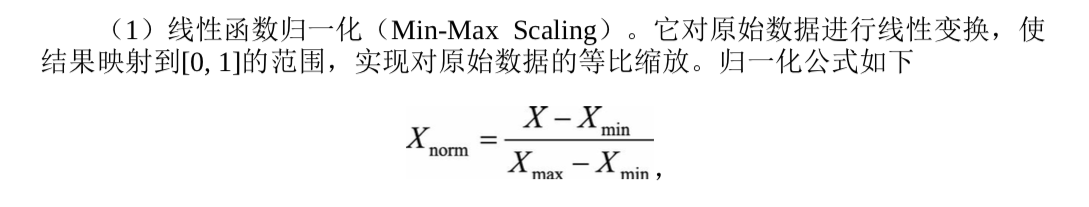

In [ ]:
#公式如上
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    #+1e-6是防止分母为0
    return data-0.5

* The dummy model is just for debugging purpose.  
假设模型仅用于调试目的。  
* Our 1D Conv model is fairly deep and is trained using Adam Optimizer with a learning rate of 0.0001  
我们的一维Conv模型非常深，使用Adam Optimizer进行训练，学习率为0.0001

![raw](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

In [ ]:
def get_1d_dummy_model(config):
    # 仅用于调试
    nclass = config.n_classes
    #类别个数
    input_length = config.audio_length
    #模型输入长度
    
    inp = Input(shape=(input_length,1))
    #keras Input ： 构建模型输入
    x = GlobalMaxPool1D()(inp)
    #keras GlobalMaxPool1D : 时序全局最大池化
    out = Dense(nclass, activation=softmax)(x)
    #全连接层，输出维度是nclass，激活函数是softmax,输入是x

    model = models.Model(inputs=inp, outputs=out)
    #keras Model:实例化一个模型
    opt = optimizers.Adam(config.learning_rate)
    #keras Adam :设置优化算法

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    #keras model compile : 本函数编译模型以供训练
    #opt是优化算法，loss是损失函数,多类的对数损失,metrics指标是准确率
    
    return model

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    #类别个数
    input_length = config.audio_length
    #模型输入长度
    
    inp = Input(shape=(input_length,1))
    #设置模型的输入
    
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)#一维卷积层（即时域卷积）
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)#一维卷积层（即时域卷积）
    x = MaxPool1D(16)(x)#为时域信号施加最大池化
    x = Dropout(rate=0.1)(x)#随机失活层
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)#全连接层
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)#输出层

    model = models.Model(inputs=inp, outputs=out)
    #keras Model:实例化一个模型
    opt = optimizers.Adam(config.learning_rate)
    #keras Adam :设置优化算法
    
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    #keras model compile : 本函数编译模型以供训练
    #opt是优化算法，loss是损失函数,多类的对数损失,metrics指标是准确率
    return model

<a id="1d_training"></a>
#### Training 1D Conv
训练1D卷积网络

It is important to convert raw labels to integer indices  
将原始标签转换为整数索引很重要

In [ ]:
LABELS = list(train.label.unique())
# 原始标签列表
label_idx = {label: i for i, label in enumerate(LABELS)}
# 字典生成式 ： 构建字典  标签：序号
train.set_index("fname", inplace=True)
#pandas set_index : 将训练集train的frame列设置为索引列，并保存修改
test.set_index("fname", inplace=True)
#pandas set_index : 将测试集test的frame列设置为索引列，并保存修改
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
#panda apply : 对每个元素操作。给train新建一列label_idx，值是标签对应的序号。
if not COMPLETE_RUN:#如果之前的COMPLETE_RUN不为空
    train = train[:2000]#训练集取前2000个
    test = test[:2000]#测试集取前2000个

In [ ]:
config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001)
#配置
if not COMPLETE_RUN:#如果COMPLETE_RUN不为空。这里缩小了数据的规模。
    config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

Here is the code for 10-fold training:  
以下是10折训练的代码：  
* We use **`from sklearn.cross_validation.StratifiedKFold`** for splitting the trainig data into 10 folds.  
我们使用sklearn.model_selection.StratifiedKFold将trainig数据分成10份。  
* We use some Keras callbacks to monitor the training.  
我们使用一些Keras回调函数来监控训练过程。  
    * **`ModelCheckpoint`** saves the best weight of our model (using validation data). We use this weight to make test predictions.  
    ModelCheckpoint保存了我们模型的最佳权重（使用验证数据）。 我们使用此权重进行测试预测。  
    * **`EarlyStopping`** stops the training once validation loss ceases to decrease  
    当验证损失函数不再下降，EarlyStopping将停止训练  
    * **`TensorBoard`** helps us visualize training and validation loss and accuracy.  
    TensorBoard帮助我们可视化培训和查看损失和准确性。  
* We fit the model using **`DataGenerator`** for training and validation splits.   
我们使用DataGenerator生成数据来进行模型拟合，以进行训练集和验证集分割。  
* We get both training and test predictions and save them as .npy format. We also generate a submission file. For 10-fold CV, the number of prediction files should be 10. We will ensemble these predictions later.  
我们得到训练和测试预测结果，并将它们保存为.npy格式。 我们还生成一个提交文件。 对于10折交叉验证，预测文件的数量应为10.我们将在稍后集成这些预测。

In [ ]:
# ```python
!export HDF5_USE_FILE_LOCKING=FALSE
#文件锁，多线程时没有这句话可能会报错

PREDICTION_FOLDER = "predictions_1d_conv"
#预测结果文件夹

if not os.path.exists(PREDICTION_FOLDER): #如果不存在这个文件夹
    os.mkdir(PREDICTION_FOLDER)#那就创建这个文件夹
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER) #删除文件夹

skf = StratifiedKFold(n_splits=config.n_folds).split(train, train.label_idx)
#keras StratifiedKFold: 
# 将全部训练集S分成k个不相交的子集，假设S中的训练样例个数为m，那么每一个自己有m/k个训练样例，相应的子集为{s1，s2，...，sk}
# 每次从分好的子集里面，拿出一个作为测试集，其他k-1个作为训练集
# 在k-1个训练集上训练出学习器模型，把这个模型放到测试集上，得到分类率的平均值，作为该模型或者假设函数的真实分类率
# skf = StratifiedKFold(n_splits=config.n_folds).split(train, train.label_idx)#这个是新版本的

for i, (train_split, val_split) in enumerate(skf):
    #i是第几次拆分，train_split是拆分后训练集的序号，val_split是拆分后测试集的序号
    train_set = train.iloc[train_split]
    #pandas iloc : 用整数索引来 取值。这里可以将训练集中的K折拆分训练集选出来
    val_set = train.iloc[val_split]
    #pandas iloc : 用整数索引来 取值。这里可以将训练集中的K折拆分测试集选出来
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    #keras :该回调函数将在每个epoch训练结束后   自动  保存模型到filepath，monitor：需要监视的值，verbose：信息展示模式，0或1，save_best_only：当设置为True时，将只保存在验证集上性能最好的模型
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    #keras :当监测值不再改善时，该回调函数将中止训练.monitor：需要监视的量.在min模式下，如果检测值停止下降则中止训练.patience：当early stop被激活（如发现loss相比上一个epoch训练没有下降），则经过patience个epoch后停止训练。
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)
    #keras TensorBoard : 该回调函数是一个可视化的展示器。log_dir：保存日志文件的地址，该文件将被TensorBoard解析以用于可视化.write_graph:是否可视化梯度直方图

    callbacks_list = [checkpoint, early, tb]
    #回调函数参数列表，用于之后传值
    
    print("Fold: ", i)
    print("#"*50)
    if COMPLETE_RUN:#大训练集
        model = get_1d_conv_model(config)
    else:#小训练集
        model = get_1d_dummy_model(config)
    #实例化一个数据生成类，得到K折拆分训练集
    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/audio_train/', train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    #实例化一个数据生成类，得到K折拆分测试集
    val_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/audio_train/', val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)
    #训练
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=False, workers=0, max_queue_size=10)
    #原作者使用的参数是：use_multiprocessing=True，workers=6.但是本地运行会报错，需要对参数做调整，还要把h5py卸载重装2.7.1 版本才不会报错。
    model.load_weights('best_%d.h5'%i)
    #keras load_weights : 从hdf5文件中加载所有神经网络层的权重(上面有个自动调用的回调函数用于保存训练的权重)
    
    
    # Save train predictions测试
    #实例化一个数据生成类，得到原训练集
    train_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_train/audio_train/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    #使用前面训练的model去预测训练集
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    #用numpy .npy文件保留预测结果
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    
    #实例化一个数据生成类，得到原测试集
    test_generator = DataGenerator(config, '../input/freesound-audio-tagging/audio_test/audio_test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    #使用前面训练的model去预测测试集
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    #用numpy .npy文件保留预测结果
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)
    
    
    # Make a submission file生成提交文件
    
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    #LABELS -> top_3  :  (2000,41) -> (2000,3)
    #numpy : 在每行，把predictions从大到小排序，取前三个的索引，根据索引，选出LABELS每行中对应的数据(类别)。即选出每个样本预测概率最大的三个类别。
    predicted_labels = [' '.join(list(x)) for x in top_3]
    #python join : 把top_3每行的3个类别，以空格隔开，组成一个字符串。(2000,3) -> (2000,)
    test['label'] = predicted_labels
    #pandas : test新增'label'一列，数据是predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
    #将结果保存到.csv文件
    # 双层括号返回的是DataFrame的形式（带label的表头且含index）
    
#     ```

<a id="1d_ensembling"></a>
#### Ensembling 1D Conv Predictions  
一维Conv模型预测值集成  
Now that we have trained our model, it is time average the predictions of 10-folds. We will try Geometric Mean averaging and see what will be our Public LB score.  
现在我们已经训练了我们的模型，现在需要平均10折(这里是2折)的预测结果。 我们将尝试几何平均值(n个变量值连乘积后开n次方)，并查看我们的公共LB(kaggle LeaderBoard)得分。

In [ ]:
pred_list = []

for i in range(2):
    #括号中的数字是数据集拆分的次数
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
    #取第i个测试结果，追加到pred_list列表中.最后的维度类似于(2, 2000, 41)
prediction = np.ones_like(pred_list[0])
#numpy ones_like : 返回与给定数组具有相同形状(2000, 41)和类型的用1填充的数组。

#求几何平均值（集成之前的多个测试文件）
for pred in pred_list:
    #pred的维度是(2000, 41)
    prediction = prediction*pred  #   pred[0]与pred[1]  对应元素相乘
prediction = prediction**(1./len(pred_list))
# 几何平均 https://en.wikipedia.org/wiki/Geometric_mean

# Make a submission file  制作最后的提交文件
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
#LABELS -> top_3  :  (2000,41) -> (2000,3)
#numpy : 在每行，把predictions从大到小排序，取前三个的索引，根据索引，选出LABELS每行中对应的数据(类别)。
# 即选出每个样本预测概率最大的三个类别。

predicted_labels = [' '.join(list(x)) for x in top_3]
#python join : 把top_3每行的3个类别，以空格隔开，组成一个字符串。(2000,3) -> (2000,)， 这是最后的提交格式哦

#2000
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
#pandas read_csv : 读取kaggle给的sample_submission.csv

# test.set_index("fname", inplace=True)
test['label'] = predicted_labels
#test新增一列label，每一行的值与predicted_labels对应

test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)
#pandas to_cvs : 将DataFrame保存为.csv文件

<a id="intro_mfcc"></a>
## <center> 3. Introuction to MFCC 使用MFCC特征从频域分类

As we have seen in the previous section, our Deep Learning models are powerful enough to classify sounds from the raw audio. We do not require any complex feature engineering. But before the Deep Learning era, people developed techniques to extract features from audio signals. It turns out that these techniques are still useful. One such technique is computing the MFCC (Mel Frquency Cepstral Coefficients) from the raw audio. Before we jump to MFCC, let's talk about extracting features from the sound.  
正如我们在上一节中看到的，我们的深度学习模型足够强大，可以对原始音频中的声音进行分类。我们不需要任何复杂的特征工程。但在深度学习时代之前，人们开发了从音频信号中提取特征的技术。事实证明，这些技术仍然有用。一种这样的技术是从原始音频计算MFCC（Mel Frquency Cepstral Coefficients梅尔频率倒谱系数）。在我们跳到MFCC之前，让我们谈谈从声音中提取特征。  

If we just want to classify some sound, we should build features that are **speaker independent**. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale.   
如果我们只想对某些声音进行分类，我们应该构建与扬声器无关的特征。任何只提供有关扬声器信息的功能（如声音的音高）对分类没有帮助。换句话说，我们应该提取依赖于音频“内容”而不是话筒的特征。此外，良好的特征提取技术应该模仿人类语音感知。我们听到的音阶的响度不是线性的。如果我们想要将声音的感知响度加倍，我们必须将8倍的能量投入其中。我们的感知系统使用log函数而不是线性函数。  

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).  
考虑到这些因素，戴维斯和梅尔斯坦在20世纪80年代提出了MFCC。 MFCC模仿人类听觉系统的响度和音高的对数感知，并试图通过排除基频和它们的谐波来消除说话者相关的特征。基础数学非常复杂，我们将跳过这一点。对于那些感兴趣的人，这里有详细的解释。

![http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png](http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png)

<a id="librosa_mfcc"></a>
#### Generating MFCC using Librosa使用Librosa库生成MFCC  
The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.  
库librosa具有计算MFCC的功能。让我们计算音频文件的MFCC并将其可视化。

http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png

In [ ]:
import librosa
#音频处理库
SAMPLE_RATE = 44100
#采样频率
fname = '../input/freesound-audio-tagging/audio_train/audio_train/' + '00044347.wav'   # Hi-hat鼓
#一个wav文件的地址

wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
#librosa.core.load : 读取音频文件并取样
#返回值data是np.ndarray形式的音频序列数据，sr是采样频率，res_type是快速类型。

wav = wav[:2*44100]
#取前2*44100帧

In [ ]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
#以numpy_ndarray的形式，返回梅尔频率倒谱系数
mfcc.shape

In [ ]:
plt.figure(figsize=(16, 4))
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

<a id="2d_model_building"></a>
## <center>4. Building a Model using MFCC

We will build now build a 2D Convolutional model using MFCC.   
我们现在将使用MFCC构建2D卷积模型。

In [ ]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
#keras layers: keras的神经网络层
#keras Convolution2D : 二维卷积层对二维输入进行滑动窗卷积
#keras GlobalAveragePooling2D : 为空域信号施加全局平均值池化
#keras BatchNormalization : 该层在每个batch上将前一层的激活值重新规范化，即使得其输出数据的均值接近0，其标准差接近1
#keras Flatten : Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
#keras GlobalMaxPool2D : 为空域信号施加全局最大值池化
#keras MaxPool2D ： 为空域信号施加最大值池化
#keras concatenate : 融合层
#keeas Activation : 激活层

from keras.utils import Sequence, to_categorical
#keras Sequence :序列数据的基类，例如一个数据集
#keras to_categorical：将类别向量(从0到nb_classes的整数向量)映射为二进制类别矩阵

from keras import backend as K
#Keras后端

In [ ]:
#测试模型
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    #类别数
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    #keras Input : 模型输入
    x = GlobalMaxPool2D()(inp)
    #keras GlovalMaxPool2D : 为空域信号施加全局最大值池化
    out = Dense(nclass, activation=softmax)(x)
    #keras Dense : 全连接层
    model = models.Model(inputs=inp, outputs=out)
    #keras Model:实例化一个模型
    opt = optimizers.Adam(config.learning_rate)
    #keras optimizers : 优化器
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    #keras model compile : 本函数编译模型以供训练
    #opt是优化算法，loss是损失函数,多类的对数损失,metrics指标是准确率
    return model

#实际用的模型
def get_2d_conv_model(config):
    
    nclass = config.n_classes
    #类别数
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    #keras Input : 模型输入
    x = Convolution2D(32, (4,10), padding="same")(inp)
    #keras Convolution2D : 二维卷积层对二维输入进行滑动窗卷积
    x = BatchNormalization()(x)
    #keras BatchNormalization ： 该层在每个batch上将前一层的激活值重新规范化，即使得其输出数据的均值接近0，其标准差接近1
    x = Activation("relu")(x)
    #keras Activation : 激活层
    x = MaxPool2D()(x)
    #keras MaxPool2D : 为空域信号施加最大值池化
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    #keras Flatten : Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。    
    x = Dense(64)(x)
    #keras Dense : 全连接层
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="2d_data"></a>
### Preparing data准备准据

In [ ]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
#实例化配置类
if not COMPLETE_RUN:
    #如果不是完全运行，减小训练量
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [ ]:
#一些预处理操作，返回梅尔频率倒谱系数
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    #numpy empty : 用零构建指定形状的数组
    input_length = config.audio_length
    #输入的长度
    for i, fname in enumerate(df.index):
        #pandas index : df.index是文件名
        print(fname)
        file_path = data_dir + fname
        #文件的路径
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")
        #读取音频文件并取样
        #返回值data是np.ndarray形式的音频序列数据，sr是采样频率，res_type是快速类型。

        # Random offset / Padding
        #如果音频长度大于模型的输入长度    过长 从中取出指定长度的音频 
        if len(data) > input_length:
            max_offset = len(data) - input_length
            # 数据长度比模型输入长度长多少
            offset = np.random.randint(max_offset)
            #在(0,max_offset)之间随机生成一个整数
            data = data[offset:(input_length+offset)]
            #随机截取一段长度为input_length的音频
        else:
            # 如果音频过短，补成指定长度
            if input_length > len(data):
                max_offset = input_length - len(data)
                # 模型输入长度比数据长度长多少
                offset = np.random.randint(max_offset)
                #在(0,max_offset)之间随机生成一个整数
            else:
                offset = 0
                #如果相等，偏移量为0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
            #nimpy pad : 在数组前后填充常数。数组原本长度是len(data)，在前面随机填充offset个常数，在后面随机填充input_length - len(data) - offset个常数，总长度变为input_length

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        #以numpy_ndarray的形式，返回梅尔频率倒谱系数
        data = np.expand_dims(data, axis=-1)
        #在数组最后添加一个维度
        X[i,] = data
        #x是模型的输入
        #X第i个元素 为 第i个处理之后的data.
    return X

In [ ]:
# ```python 这里会生成很多废话，我不知道怎么关，耐心翻吧少年
X_train = prepare_data(train, config, '../input/freesound-audio-tagging/audio_train/audio_train/')
#得到处理好的训练集
test.set_index("fname", inplace=True)
#不加上面这句话会报错。
#pandas set_index : 将测试集test的frame列设置为索引列，并保存修改
X_test = prepare_data(test, config, '../input/freesound-audio-tagging/audio_test/audio_test/')
#得到处理好的测试集
y_train = to_categorical(train.label_idx, num_classes=config.n_classes)
#将类别向量(从0到nb_classes的整数向量)映射为二进制类别矩阵
fan='julyfan'
fan
# ```

<a id="2d_normalization"></a>
#### Normalization  
归一化

线性函数归一化（摘自百面机器学习）  
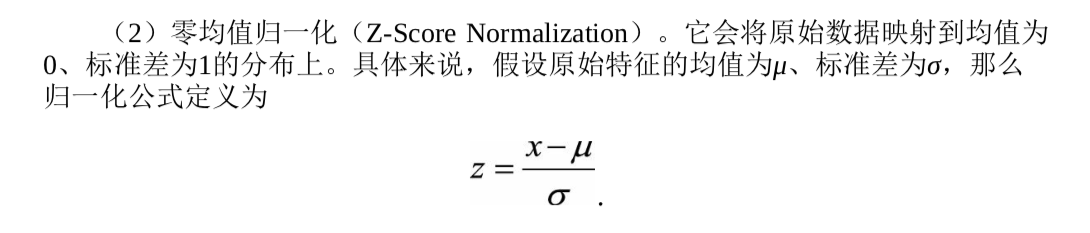

In [ ]:
#这里关闭注释，就是归一化
# mean = np.mean(X_train, axis=0)#均值
# std = np.std(X_train, axis=0)#方差

# X_train = (X_train - mean)/std#训练集归一化
# X_test = (X_test - mean)/std#测试集归一化


<a id="2d_training"></a>
#### Training 2D Conv on MFCC 训练，生成多个提交文件(K折)

In [ ]:
# ```python
PREDICTION_FOLDER = "predictions_2d_conv"
#文件夹的名字
if not os.path.exists(PREDICTION_FOLDER):#如果不存在这个文件夹
    os.mkdir(PREDICTION_FOLDER)#那就创建这个文件夹
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)#删除目录

# skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds) 作者写的代码已经被移除了
skf = StratifiedKFold(n_splits=config.n_folds).split(train, train.label_idx)
# keras StratifiedKFold: 
# 将全部训练集S分成k个不相交的子集，假设S中的训练样例个数为m，那么每一个自己有m/k个训练样例，相应的子集为{s1，s2，...，sk}
# 每次从分好的子集里面，拿出一个作为测试集，其他k-1个作为训练集
# 在k-1个训练集上训练出学习器模型，把这个模型放到测试集上，得到分类率的平均值，作为该模型或者假设函数的真实分类率
# skf = StratifiedKFold(n_splits=config.n_folds).split(train, train.label_idx)#这个是新版本的

for i, (train_split, val_split) in enumerate(skf):
    #i是第几次拆分，train_split是拆分后训练集的序号，val_split是拆分后测试集的序号
    K.clear_session()
    #keras clear_session : 结束当前的TF计算图，并新建一个。有效的避免模型/层的混乱
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    #K折分割训练集。
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    #keras ModelCheckpoint : 该回调函数将在每个epoch训练结束后  自动   保存模型到filepath，monitor：需要监视的值，verbose：信息展示模式，0或1，save_best_only：当设置为True时，将只保存在验证集上性能最好的模型
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    #keras EarlyStopping : 当监测值不再改善时，该回调函数将中止训练.monitor：需要监视的量.在min模式下，如果检测值停止下降则中止训练.patience：当early stop被激活（如发现loss相比上一个epoch训练没有下降），则经过patience个epoch后停止训练。
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    #keras TensorBoard : 该回调函数是一个可视化的展示器。log_dir：保存日志文件的地址，该文件将被TensorBoard解析以用于可视化.write_graph:是否可视化梯度直方图
    callbacks_list = [checkpoint, early, tb]
    #回调函数参数列表，用于之后传值
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    #调用自定义函数，构造复杂模型
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    #训练
    
    model.load_weights('best_%d.h5'%i)
    #keras load_weights : 从hdf5文件中加载所有神经网络层的权重
    
    # Save train predictions
    #使用前面训练的model去预测测试集
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    #用numpy .npy文件保留预测结果
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    #使用前面训练的model去预测测试集
    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    #用numpy .npy文件保留预测结果
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file制作提价文件
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    #LABELS -> top_3  :  (2000,41) -> (2000,3)
    #numpy : 在每行，把predictions从大到小排序，取前三个的索引，根据索引，选出LABELS每行中对应的数据(类别)。
    #即选出每个样本预测概率最大的三个类别。
    
    predicted_labels = [' '.join(list(x)) for x in top_3]
    #python join : 把top_3每行的3个类别，以空格隔开，组成一个字符串。(2000,3) -> (2000,)
    
    test['label'] = predicted_labels
    #test新增一列label，值一行的值与predicted_labels对应
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
    #pandas to_cvs : 将DataFrame保存为.csv文件
# ```

<a id="2d_ensembling"></a>
#### Ensembling 2D Conv Predictions
二维Convk折预测值集成

In [ ]:
pred_list = []

for i in range(2):
    #括号中的数字是数据集拆分的次数
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
    #取第i个测试结果，追加到pred_list列表中.最后的维度类似于(2, 9400, 41)
prediction = np.ones_like(pred_list[0])
#numpy ones_like : 返回与给定数组具有相同形状(9400, 41)和类型的用1填充的数组。

#求几何平均值
for pred in pred_list:
    #pred的维度是(9400, 41)
    prediction = prediction*pred #pred[0] pred[1] 对应元素相乘
prediction = prediction**(1./len(pred_list))
#求几何平均

# Make a submission file制作提价文件
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
#LABELS -> top_3  :  (9400,41) -> (9400,3)
#numpy : 在每行，把predictions从大到小排序，取前三个的索引，根据索引，选出LABELS每行中对应的数据(类别)。
# 即选出每个样本预测概率最大的三个类别。

predicted_labels = [' '.join(list(x)) for x in top_3]
#python join : 把top_3每行的3个类别，以空格隔开，组成一个字符串。(9400,3) -> (9400,)

#9400
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
#pandas read_csv : 读取kaggle给的sample_submission.csv

# test.set_index("fname", inplace=True)
test['label'] = predicted_labels
#test新增一列label，每一行的值与predicted_labels对应

test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)
#pandas to_cvs : 将DataFrame保存为.csv文件

<a id="1d_2d_ensembling"></a>
## <center>5. Ensembling 1D Conv and 2D Conv Predictions</center>  
深度学习方法1维卷积 和 MFCC方法2 的预测值集成

In [ ]:
pred_list = []
# for i in range(10):
#     pred_list.append(np.load("../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_%d.npy"%i))
for i in range(2):
    pred_list.append(np.load("../input/freesound-prediction-data-2d-conv-reduced-lr/test_predictions_%d.npy"%i))
    #取第i个1d_conv测试结果，追加到pred_list列表中.最后的维度类似于(4, 2000, 41)    
for i in range(2):
    pred_list.append(np.load("../input/freesound-prediction-file/test_predictions_%d.npy"%i))
    #取第i个2d_conv测试结果，追加到pred_list列表中.最后的维度类似于(4, 2000, 41)    
prediction = np.ones_like(pred_list[0])
#numpy ones_like : 返回与给定数组具有相同形状(2000, 41)和类型的用1填充的数组。

#求几何平均值
for pred in pred_list:
    #pred的维度是(2000, 41)
    prediction = prediction*pred
    #np * : 对应元素相乘
    #n个变量值连乘积
prediction = prediction**(1./len(pred_list))
#求平均

# Make a submission file制作提价文件
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
#LABELS -> top_3  :  (2000,41) -> (2000,3)
#numpy : 在每行，把predictions从大到小排序，取前三个的索引，根据索引，选出LABELS每行中对应的数据(类别)。
# 即选出每个样本预测概率最大的三个类别。

predicted_labels = [' '.join(list(x)) for x in top_3]
#python join : 把top_3每行的3个类别，以空格隔开，组成一个字符串。(2000,3) -> (2000,)

test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
#pandas read_csv : 读取kaggle给的sample_submission.csv

test['label'] = predicted_labels
#test新增一列label，每一行的值与predicted_labels对应

test[['fname', 'label']].to_csv("1d_2d_ensembled_submission.csv", index=False)
#pandas to_cvs : 将DataFrame保存为.csv文件

<a id="conclusion"></a>
## <center>Results and Conclusion</center>  
结果与展望

So far, we have trained two models. Let's analyze their relative complexity and strength.  
到目前为止，我们已经训练了两个模型。 让我们分析它们的相对复杂性和好坏。   



| Model        | Number of Trainable parameters           | Public LB score  |
| ------------- |:-------------:| -----:|
| 1D Conv on Raw wave(方法一)      | 360,513 | 0.809 |
| 2D Conv on MFCC (verified labels only)    | 168,361  |   0.785 |
| 2D Conv on MFCC(方法二)     | 168,361  |   0.844 |
| 1D Conv + 2D Conv Ensemble(法1+法二)     | N/A  |   0.895 |

**As we can see, 2D Convolution on MFCC performs better than 1D Convolution on Raw waves.**  
原作者最终跑出来的结果发现法二MFCC比法一深度学习一维卷积效果更好

## Coming Soon  
接下来的工作  

1. Data Augmentation数据增强  
2. Training on Manually Verified Labels在手工验证集上训练